In [636]:
import numpy as np
import pandas as pd
import joblib
from keras import Sequential
from keras.layers import Dense, GRU, LSTM, Dropout, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from matplotlib import pyplot as plt

In [637]:
def create_multivariate_time_series(data, n_past, target_col=0, feature_cols=None):
    if feature_cols is None:
        feature_cols = list(range(data.shape[1]))

    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, feature_cols])
        y.append(data[i, target_col])

    return np.array(X), np.array(y)

In [638]:
def build_GRU_model(input_shape):
    model = Sequential(name="GRU")

    model.add(Input(shape=input_shape))
    model.add(GRU(units=128, return_sequences=True))

    model.add(GRU(units=64, return_sequences=True))

    model.add(GRU(units=32))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    return model

In [639]:
def build_LSTM_model(input_shape):
    model = Sequential(name="LSTM")

    model.add(Input(shape=input_shape))
    model.add(LSTM(units=256, return_sequences=True))

    model.add(LSTM(units=128, return_sequences=True))

    model.add(LSTM(units=64))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    return model

In [640]:
df = pd.read_csv("../data/processed/mbajk_processed.csv")
df.head()

,available_bike_stands,apparent_temperature,surface_pressure,temperature,dew_point,date
0,8,24.7,984.3,25.1,12.4,2023-06-25 19:07:30+00:00
1,7,23.3,984.5,24.2,10.9,2023-06-25 19:33:48+00:00
2,6,23.3,984.5,24.2,10.9,2023-06-25 19:45:44+00:00
3,8,23.3,984.5,24.2,10.9,2023-06-25 19:55:29+00:00
4,12,23.3,984.5,24.2,10.9,2023-06-25 20:02:16+00:00


In [641]:
df.shape

(18692, 6)

In [642]:
target = "available_bike_stands"
features = [target] + [col for col in df.columns if col != target and col != "date"]

dataset = df[features]

In [643]:
dataset.shape

(18692, 5)

In [644]:
test_split = round(len(dataset) * 0.2)

train_data = dataset[:-test_split]
test_data = dataset[-test_split:]

In [645]:
print(train_data.shape, test_data.shape)

(14954, 5) (3738, 5)


In [646]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [647]:
window_size = 10

target_col_idx = df.columns.get_loc(target)

feature_cols_idx = [df.columns.get_loc(col) for col in features]

print(f"Target column index: {target_col_idx}")
print(f"Feature columns index: {feature_cols_idx}")

Target column index: 0
Feature columns index: [0, 1, 2, 3, 4]


In [648]:
X_train, y_train = create_multivariate_time_series(train_data, window_size, target_col_idx, feature_cols_idx)
X_test, y_test = create_multivariate_time_series(test_data, window_size, target_col_idx, feature_cols_idx)

print(f"Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of training data: X_train: (14944, 10, 5), y_train: (14944,)
Shape of testing data: X_test: (3728, 10, 5), y_test: (3728,)


In [649]:
input_shape = (X_train.shape[1], X_train.shape[2])

models = [build_GRU_model(input_shape)]

history = {}

In [650]:
for model in models:
    print(f"Training {model.name} model")
    fit_result = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)
    history[model.name] = fit_result.history

Training GRU model
Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1126 - val_loss: 0.0051
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0029 - val_loss: 0.0063
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0027 - val_loss: 0.0043


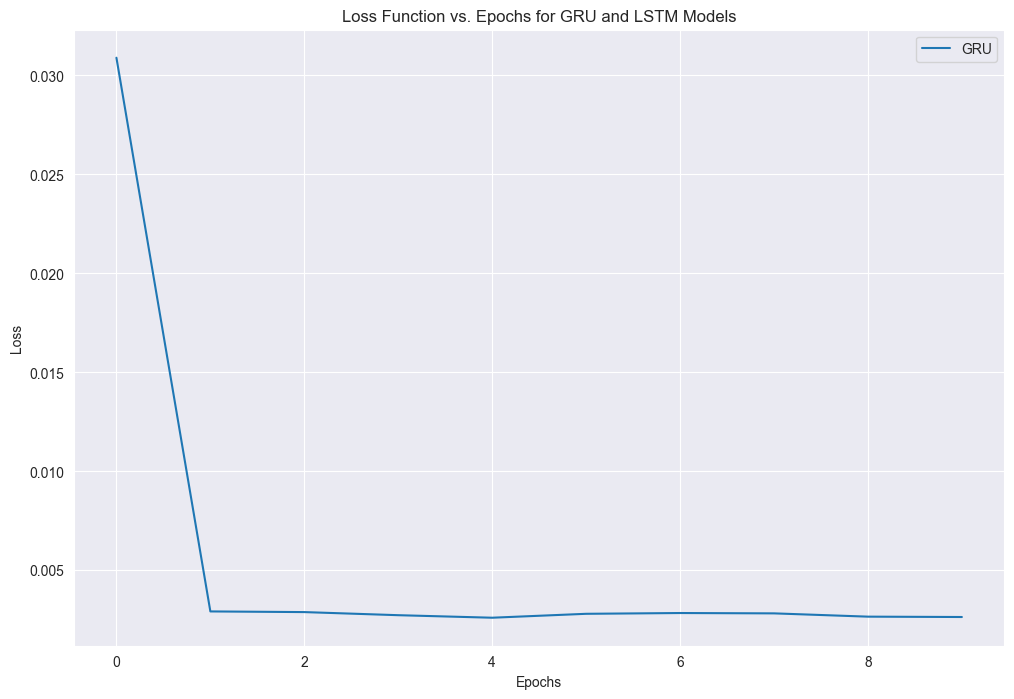

In [651]:
plt.figure(figsize=(12, 8))
for name, values in history.items():
    plt.plot(values['loss'], label=name)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs for GRU and LSTM Models')
plt.legend()
plt.show()

In [652]:
y_test_copy = np.repeat(y_test, dataset.shape[1], axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copy, (len(y_test), dataset.shape[1])))[:, 0]

In [653]:
y_test

array([ 2.,  2.,  2., ..., 13., 11., 11.])

In [654]:
results = {
    "MAE": [],
    "MSE": [],
    "EVS": []
}

for model in models:
    predicted = model.predict(X_test)

    prediction_copies = np.repeat(predicted, dataset.shape[1], axis=-1)
    predicted = scaler.inverse_transform(np.reshape(prediction_copies, (len(predicted), dataset.shape[1])))[:, 0]

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)

    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')
    print("-" * 20)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
GRU - MSE: 2.07
GRU - MAE: 0.97
GRU - EVS: 0.96
--------------------


In [655]:
prediction = models[0].predict(X_test)
prediction_copy_array = np.repeat(prediction, dataset.shape[1], axis=-1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [656]:
pred = scaler.inverse_transform(np.reshape(prediction_copy_array, (len(prediction), dataset.shape[1])))[:, 0]

In [657]:
dates = df['date'].values
df_output = pd.DataFrame({"date": dates[-test_split + window_size:], 'Actual': y_test, 'Predicted': pred})
df_output.head(20)

,date,Actual,Predicted
0,2023-09-15 01:50:45+00:00,2.0,2.728415
1,2023-09-15 02:00:50+00:00,2.0,2.712614
2,2023-09-15 02:10:56+00:00,2.0,2.726594
3,2023-09-15 02:21:01+00:00,2.0,2.733269
4,2023-09-15 02:31:07+00:00,2.0,2.727649
5,2023-09-15 02:41:12+00:00,2.0,2.713106
6,2023-09-15 02:51:17+00:00,2.0,2.728305
7,2023-09-15 03:01:23+00:00,2.0,2.734584
8,2023-09-15 03:11:28+00:00,2.0,2.711824
9,2023-09-15 03:21:33+00:00,2.0,2.691854


In [658]:
# joblib.dump(scaler, "../models/mbajk_scaler.pkl")
# model.save(f"../models/mbajk_{model.name}_model.keras")